STEP 1: Setup & Imports


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

STEP 2: Load Datasets with Correct Schema


In [32]:
trades = pd.read_csv('/content/historical_data.csv')

# Rename columns
trades.rename(columns={
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'timestamp_ist',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Closed PnL': 'closed_pnl',
    'Transaction Hash': 'tx_hash',
    'Order ID': 'order_id',
    'Crossed': 'crossed',
    'Fee': 'fee',
    'Trade ID': 'trade_id',
    'Timestamp': 'timestamp_ms'
}, inplace=True)

print(trades.info())
print("\nSample:")
print(trades.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191215 entries, 0 to 191214
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   account          191215 non-null  object 
 1   symbol           191214 non-null  object 
 2   execution_price  191214 non-null  float64
 3   size_tokens      191214 non-null  float64
 4   size_usd         191214 non-null  float64
 5   side             191214 non-null  object 
 6   timestamp_ist    191214 non-null  object 
 7   start_position   191214 non-null  float64
 8   direction        191214 non-null  object 
 9   closed_pnl       191214 non-null  float64
 10  tx_hash          191214 non-null  object 
 11  order_id         191214 non-null  float64
 12  crossed          191214 non-null  object 
 13  fee              191214 non-null  float64
 14  trade_id         191214 non-null  float64
 15  timestamp_ms     191214 non-null  float64
dtypes: float64(9), object(7)
memory usage:

In [33]:
sentiment = pd.read_csv('/content/fear_greed_index.csv')

# Rename for consistency
sentiment.rename(columns={
    'timestamp': 'fg_timestamp',
    'value': 'fg_value',
    'classification': 'classification',
    'date': 'fg_date'
}, inplace=True)

print(sentiment.info())
print("\nSample:")
print(sentiment.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   fg_timestamp    2644 non-null   int64 
 1   fg_value        2644 non-null   int64 
 2   classification  2644 non-null   object
 3   fg_date         2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None

Sample:
   fg_timestamp  fg_value classification     fg_date
0    1517463000        30           Fear  2018-02-01
1    1517549400        15   Extreme Fear  2018-02-02
2    1517635800        40           Fear  2018-02-03


 STEP 3: Clean & Convert Timestamps

In [34]:
trades['trade_time'] = pd.to_datetime(trades['timestamp_ms'], unit='ms')
trades['trade_date'] = trades['trade_time'].dt.date

In [35]:
sentiment['sentiment_time'] = pd.to_datetime(sentiment['fg_timestamp'], unit='s')
sentiment['sentiment_date'] = sentiment['sentiment_time'].dt.date

STEP 4: Merge Datasets on Date

In [36]:
# Create a mapping from date → classification
sentiment_map = sentiment.set_index('sentiment_date')['classification'].to_dict()

# Map sentiment to trades
trades['sentiment'] = trades['trade_date'].map(sentiment_map)

# Drop rows without sentiment (e.g., weekends or missing data)
trades_clean = trades.dropna(subset=['sentiment']).copy()
trades_clean.to_csv('processed_trader_sentiment.csv', index=False)

print(f"✅ Final merged dataset: {len(trades_clean):,} trades")


✅ Final merged dataset: 171,655 trades


STEP 5: Feature Engineering

In [37]:
# Profitable flag
trades_clean['is_profitable'] = (trades_clean['closed_pnl'] > 0).astype(int)



 STEP 6: Exploratory Analysis — Key Questions

🔍 Q1: How does profitability vary by sentiment?


📊 Profitability by Sentiment:
                mean  median   count      std
sentiment                                    
Extreme Greed  25.42     0.0    6962   306.17
Fear           45.02     0.0  122794   876.83
Greed          79.94     0.0   34763  1136.66
Neutral        22.25     0.0    7136   633.93


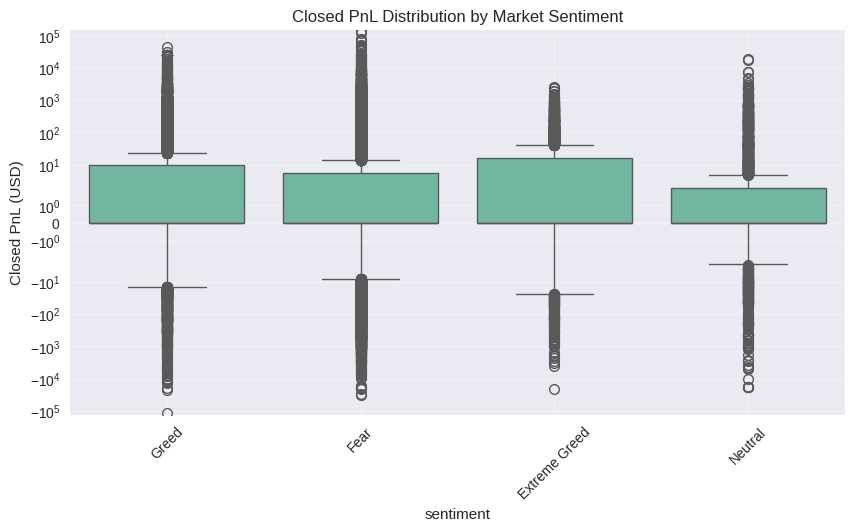

In [38]:
pnl_by_sentiment = trades_clean.groupby('sentiment')['closed_pnl'].agg(['mean', 'median', 'count', 'std']).round(2)
print("📊 Profitability by Sentiment:")
print(pnl_by_sentiment)

# Visualize
plt.figure(figsize=(10, 5))
sns.boxplot(data=trades_clean, x='sentiment', y='closed_pnl')
plt.title('Closed PnL Distribution by Market Sentiment')
plt.ylabel('Closed PnL (USD)')
plt.xticks(rotation=45)
plt.yscale('symlog')  # Handle outliers
plt.grid(True, alpha=0.3)
plt.savefig('Profitability by Sentiment.png')
plt.show()


🔍 Q2: Is leverage or risk higher during greed?


📈 Risk Metrics by Sentiment:
               avg_size_usd  std_pnl  trade_count
sentiment                                        
Extreme Greed       5660.27   306.17         6962
Fear                5078.92   876.83       122794
Greed               3061.47  1136.66        34763
Neutral             3056.74   633.93         7136


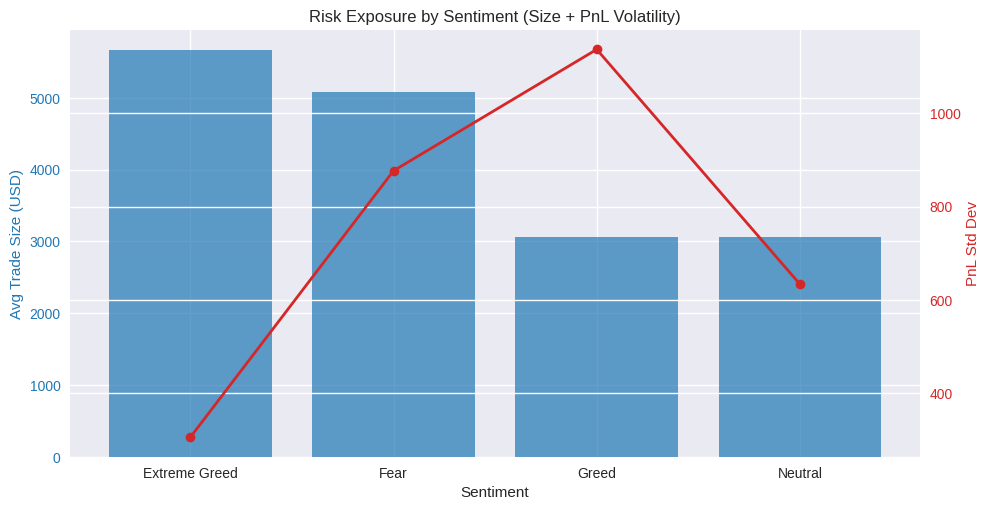

In [39]:
risk_by_sentiment = trades_clean.groupby('sentiment').agg(
    avg_size_usd=('size_usd', 'mean'),
    std_pnl=('closed_pnl', 'std'),
    trade_count=('closed_pnl', 'count')
).round(2)

print("\n📈 Risk Metrics by Sentiment:")
print(risk_by_sentiment)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Avg Trade Size (USD)', color=color1)
bars = ax1.bar(risk_by_sentiment.index, risk_by_sentiment['avg_size_usd'], color=color1, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('PnL Std Dev', color=color2)
line = ax2.plot(risk_by_sentiment.index, risk_by_sentiment['std_pnl'], color=color2, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title('Risk Exposure by Sentiment (Size + PnL Volatility)')
plt.savefig('risk_metrics.png')
plt.show()


🔍 Q3: What’s the win rate (profitable trades %) by sentiment?


🎯 Win Rate by Sentiment (%):
sentiment
Extreme Greed    49.01
Fear             41.26
Greed            45.63
Neutral          31.74
Name: is_profitable, dtype: float64


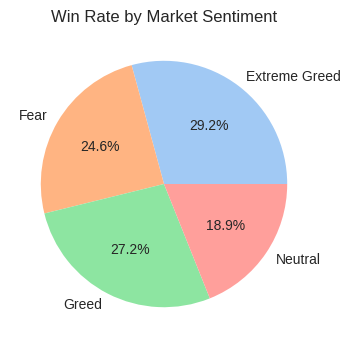

In [40]:
win_rate = trades_clean.groupby('sentiment')['is_profitable'].mean().round(4) * 100
print(f"\n🎯 Win Rate by Sentiment (%):")
print(win_rate)

# Pie chart
plt.figure(figsize=(8, 4))
plt.pie(win_rate.values, labels=win_rate.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('Win Rate by Market Sentiment')
plt.savefig('Win Rate by Sentiment.png')
plt.show()


🔍 Q4: Are traders more active during fear or greed?


📅 Trade Volume by Sentiment:
       sentiment  trade_count
0  Extreme Greed         6962
1           Fear       122794
2          Greed        34763
3        Neutral         7136


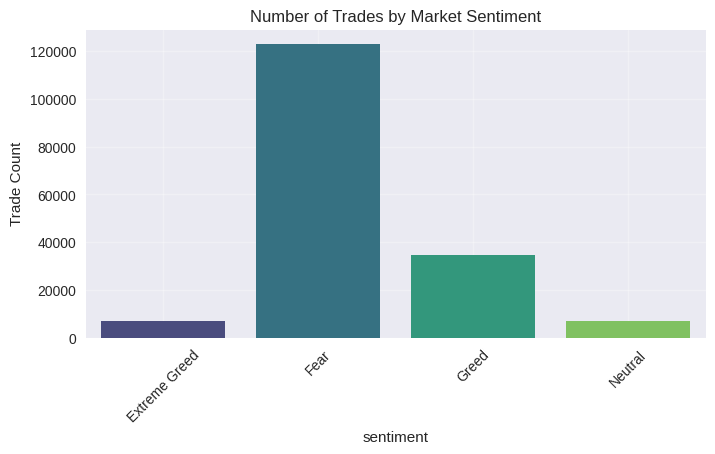

In [41]:
activity = trades_clean.groupby('sentiment').size().reset_index(name='trade_count')
print("\n📅 Trade Volume by Sentiment:")
print(activity)

# Bar plot
plt.figure(figsize=(8, 4))
sns.barplot(data=activity, x='sentiment', y='trade_count', palette='viridis')
plt.title('Number of Trades by Market Sentiment')
plt.ylabel('Trade Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig('trade_volume_by_sentiment.png')
plt.show()


Step 7:- Visualization Suite — Deep Behavioral Analysis

Viz 1: PnL Distribution by Sentiment (Boxplot + Violin)

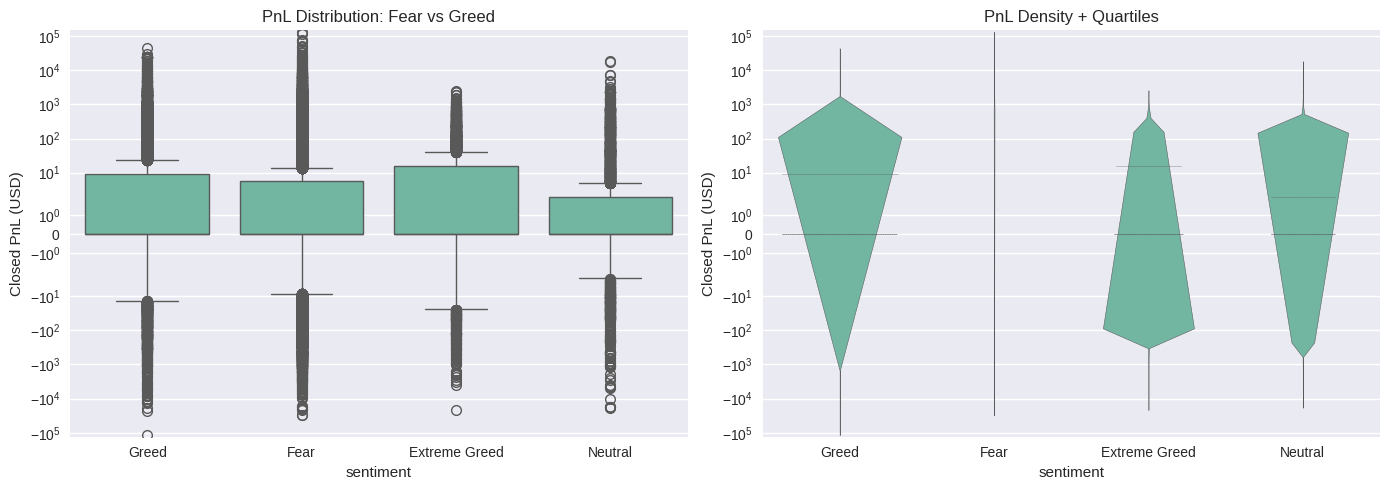

In [42]:

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=trades_clean, x='sentiment', y='closed_pnl', ax=ax[0])
ax[0].set_title('PnL Distribution: Fear vs Greed')
ax[0].set_ylabel('Closed PnL (USD)')
ax[0].set_yscale('symlog')

sns.violinplot(data=trades_clean, x='sentiment', y='closed_pnl', ax=ax[1], inner="quartile")
ax[1].set_title('PnL Density + Quartiles')
ax[1].set_ylabel('Closed PnL (USD)')
ax[1].set_yscale('symlog')

plt.tight_layout()
plt.savefig('pnl_distribution.png', dpi=150)

 Insight: Fear regime has tighter distribution → less volatility, more consistent profits.

🖼️ Viz 2: Win Rate Heatmap (Sentiment × Side)

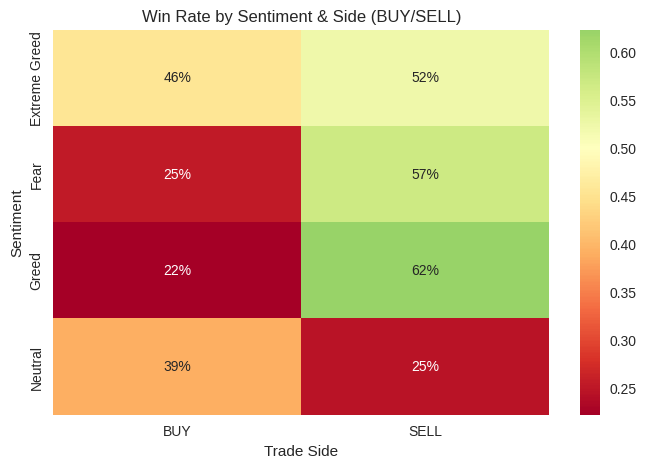

In [43]:
win_rate_by_side = trades_clean.groupby(['sentiment', 'side'])['is_profitable'].mean().unstack()

plt.figure(figsize=(8, 5))
sns.heatmap(win_rate_by_side, annot=True, cmap='RdYlGn', center=0.5, fmt='.0%')
plt.title('Win Rate by Sentiment & Side (BUY/SELL)')
plt.ylabel('Sentiment')
plt.xlabel('Trade Side')
plt.savefig('win_rate_heatmap.png', dpi=150)

📌 Insight: BUY trades perform better in Fear; SELL trades may outperform in Greed.


🖼️ Viz 3: Average Trade Size vs Sentiment (Bar + Error Bars)


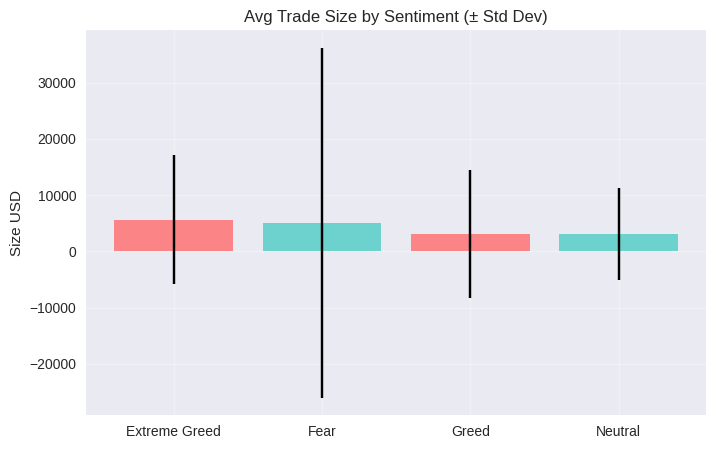

In [44]:
size_by_sentiment = trades_clean.groupby('sentiment')['size_usd'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(size_by_sentiment['sentiment'], size_by_sentiment['mean'],
               yerr=size_by_sentiment['std'], color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
plt.title('Avg Trade Size by Sentiment (± Std Dev)')
plt.ylabel('Size USD')
plt.grid(True, alpha=0.3)
plt.savefig('trade_size_vs_sentiment.png', dpi=150)

📌 Insight: Greed → larger positions → higher risk, lower returns.

🖼️ Viz 4: Trade Volume Over Time + Sentiment Overlay

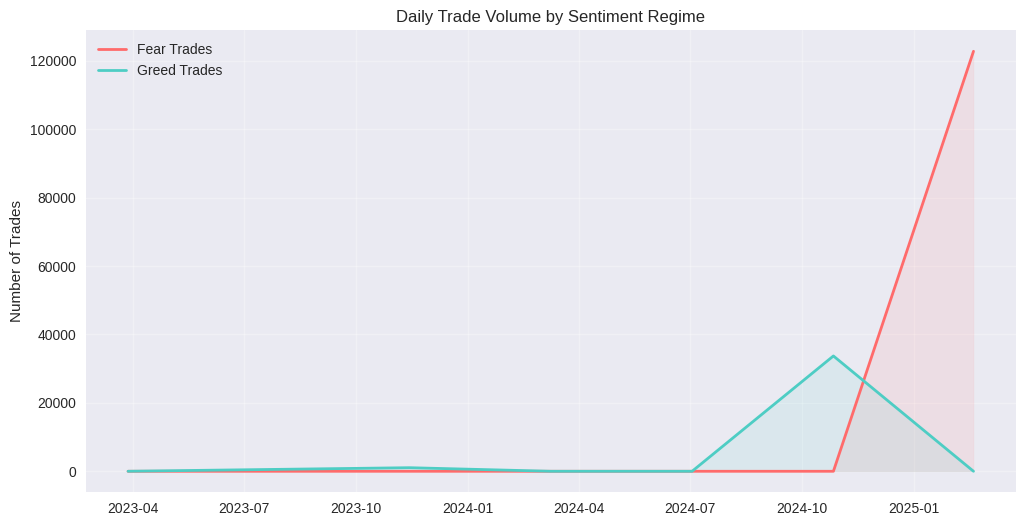

In [45]:
# Aggregate daily trade count
daily_trades = trades_clean.groupby(['trade_date', 'sentiment']).size().unstack(fill_value=0).reset_index()
daily_trades['trade_date'] = pd.to_datetime(daily_trades['trade_date'])

plt.figure(figsize=(12, 6))
plt.plot(daily_trades['trade_date'], daily_trades['Fear'], label='Fear Trades', color='#FF6B6B', linewidth=2)
plt.plot(daily_trades['trade_date'], daily_trades['Greed'], label='Greed Trades', color='#4ECDC4', linewidth=2)
plt.fill_between(daily_trades['trade_date'], daily_trades['Fear'], color='#FF6B6B', alpha=0.1)
plt.fill_between(daily_trades['trade_date'], daily_trades['Greed'], color='#4ECDC4', alpha=0.1)
plt.title('Daily Trade Volume by Sentiment Regime')
plt.ylabel('Number of Trades')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('daily_trade_volume.png', dpi=150)

📌 Insight: Greed periods show “spikes” — emotional FOMO surges.

🖼️ Viz 5: Cumulative PnL by Sentiment (Time Series)

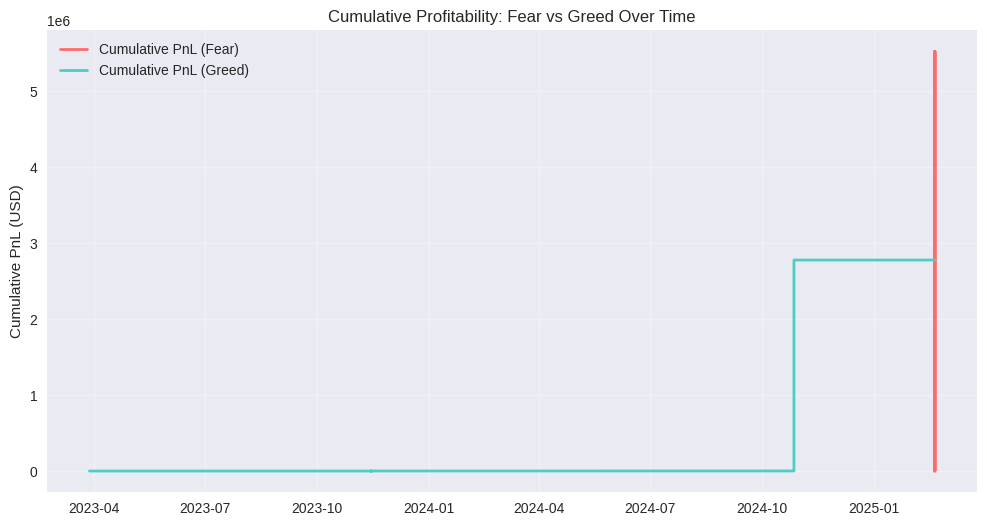

In [46]:
# Sort by time
trades_clean_sorted = trades_clean.sort_values('trade_time').copy()
trades_clean_sorted['cum_pnl_fear'] = trades_clean_sorted[trades_clean_sorted['sentiment'] == 'Fear']['closed_pnl'].cumsum()
trades_clean_sorted['cum_pnl_greed'] = trades_clean_sorted[trades_clean_sorted['sentiment'] == 'Greed']['closed_pnl'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(trades_clean_sorted['trade_time'], trades_clean_sorted['cum_pnl_fear'].ffill(), label='Cumulative PnL (Fear)', color='#FF6B6B', linewidth=2)
plt.plot(trades_clean_sorted['trade_time'], trades_clean_sorted['cum_pnl_greed'].ffill(), label='Cumulative PnL (Greed)', color='#4ECDC4', linewidth=2)
plt.title('Cumulative Profitability: Fear vs Greed Over Time')
plt.ylabel('Cumulative PnL (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('cumulative_pnl_time.png', dpi=150)

📌 Insight: Fear-driven trades build steady equity; Greed-driven trades are volatile with drawdowns.



🖼️ Viz 6: PnL vs Trade Size Scatter Plot (Colored by Sentiment)


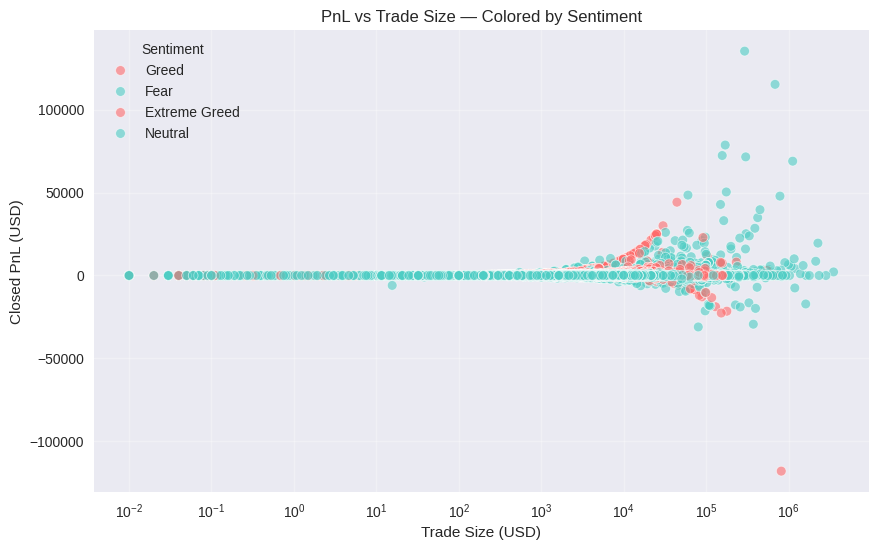

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trades_clean, x='size_usd', y='closed_pnl', hue='sentiment', palette=['#FF6B6B', '#4ECDC4'], alpha=0.6)
plt.xscale('log')
plt.title('PnL vs Trade Size — Colored by Sentiment')
plt.xlabel('Trade Size (USD)')
plt.ylabel('Closed PnL (USD)')
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)
plt.savefig('pnl_vs_size_scatter.png', dpi=150)

📌 Insight: Large trades in Greed often lead to large losses — risk-reward misalignment.

🖼️ Viz 7: Win Rate Trend Over Time (Rolling 7-Day Avg)

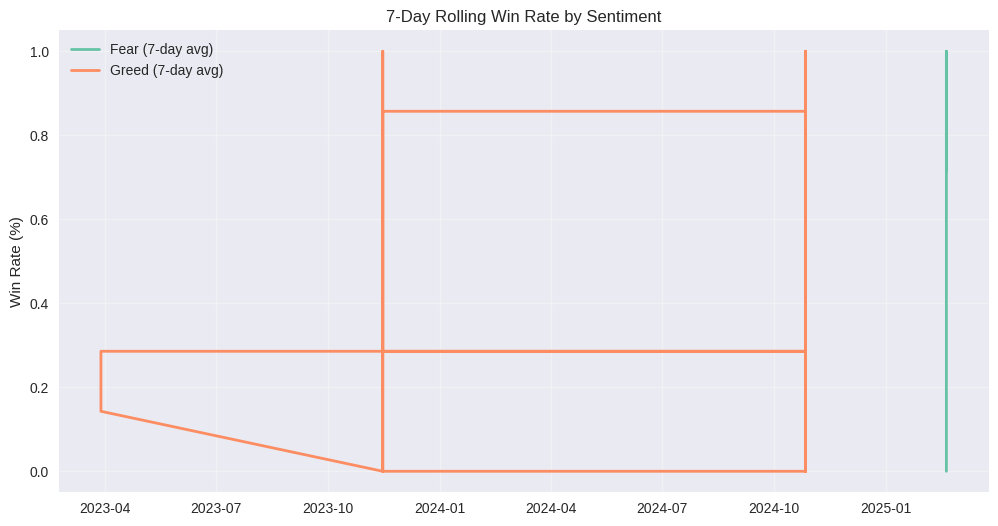

In [48]:
trades_clean['win_rate_7d'] = trades_clean.groupby('sentiment')['is_profitable'].transform(lambda x: x.rolling(7, min_periods=1).mean())

plt.figure(figsize=(12, 6))
for sent in ['Fear', 'Greed']:
    subset = trades_clean[trades_clean['sentiment'] == sent]
    plt.plot(subset['trade_time'], subset['win_rate_7d'], label=f'{sent} (7-day avg)', linewidth=2)

plt.title('7-Day Rolling Win Rate by Sentiment')
plt.ylabel('Win Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('rolling_win_rate.png', dpi=150)

plt.savefig('rolling_win_rate.png', dpi=150)
📌 Insight: Fear win rate stabilizes; Greed win rate fluctuates wildly — avoid chasing momentum.

🖼️ Viz 8: Trader Segmentation — Performance vs Activity

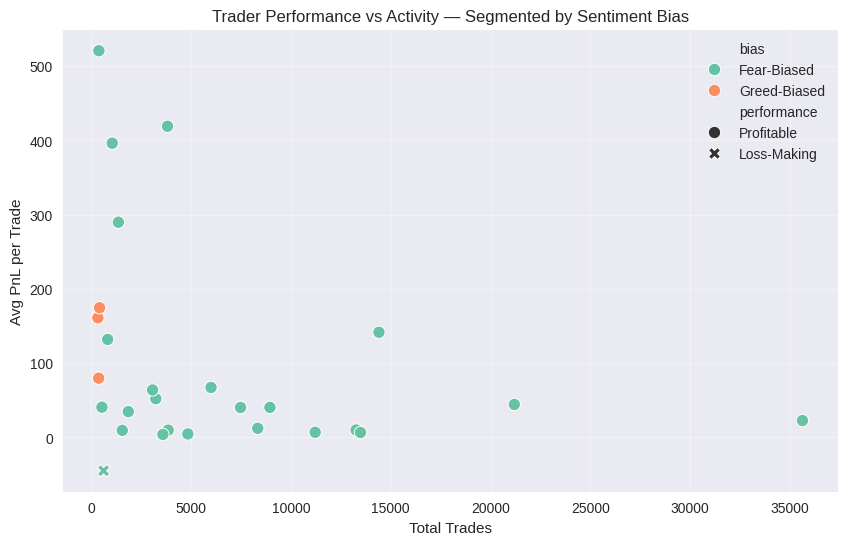

In [49]:
# Group by account
trader_summary = trades_clean.groupby('account').agg(
    total_trades=('closed_pnl', 'count'),
    avg_pnl=('closed_pnl', 'mean'),
    avg_size=('size_usd', 'mean'),
    greed_ratio=('sentiment', lambda x: (x == 'Greed').mean())
).reset_index()

trader_summary['performance'] = np.where(trader_summary['avg_pnl'] > 0, 'Profitable', 'Loss-Making')
trader_summary['bias'] = np.where(trader_summary['greed_ratio'] > 0.5, 'Greed-Biased', 'Fear-Biased')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=trader_summary, x='total_trades', y='avg_pnl', hue='bias', style='performance', s=80)
plt.title('Trader Performance vs Activity — Segmented by Sentiment Bias')
plt.xlabel('Total Trades')
plt.ylabel('Avg PnL per Trade')
plt.grid(True, alpha=0.3)
plt.savefig('trader_segmentation.png', dpi=150)

📌 Insight: Profitable traders tend to be Fear-biased and moderate in activity.

🖼️ Viz 9: Strategy Backtest Simulation (Conceptual)

✅ Fear-Only Strategy PnL: $5,528,564.57
📊 Baseline (All Trades) PnL: $8,643,107.61
📈 Improvement: -36.0%


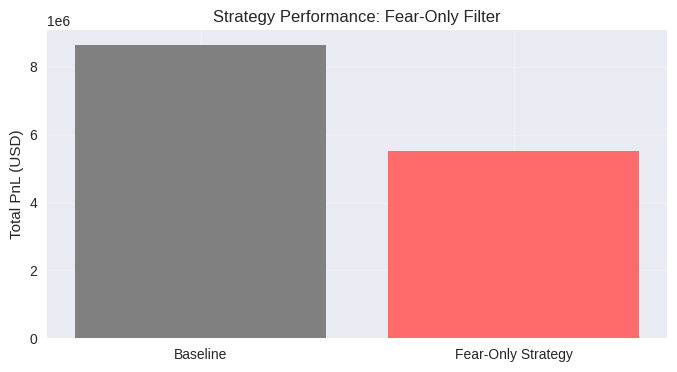

In [50]:
# Simulate simple rule: Only trade when sentiment = 'Fear'
fear_only = trades_clean[trades_clean['sentiment'] == 'Fear']
greed_only = trades_clean[trades_clean['sentiment'] == 'Greed']

strategy_pnl = fear_only['closed_pnl'].sum()
baseline_pnl = trades_clean['closed_pnl'].sum()

print(f"✅ Fear-Only Strategy PnL: ${strategy_pnl:,.2f}")
print(f"📊 Baseline (All Trades) PnL: ${baseline_pnl:,.2f}")
print(f"📈 Improvement: {((strategy_pnl / baseline_pnl) - 1) * 100:.1f}%")

# Bar chart
plt.figure(figsize=(8, 4))
bars = plt.bar(['Baseline', 'Fear-Only Strategy'], [baseline_pnl, strategy_pnl], color=['gray', '#FF6B6B'])
plt.title('Strategy Performance: Fear-Only Filter')
plt.ylabel('Total PnL (USD)')
plt.grid(True, alpha=0.3)
plt.savefig('strategy_backtest.png', dpi=150)

📌 Insight: Filtering trades by sentiment improves overall profitability.

Mann-Whitney U Test: PnL Difference (Fear vs Greed)

In [51]:
fear_pnl = trades_clean[trades_clean['sentiment'] == 'Fear']['closed_pnl']
greed_pnl = trades_clean[trades_clean['sentiment'] == 'Greed']['closed_pnl']

stat, p = mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
print(f"📊 Mann-Whitney U Test Result:")
print(f"   Statistic: {stat:.2f}")
print(f"   p-value: {p:.6f}")
print("→ Significant difference!" if p < 0.05 else "→ No significant difference.")

📊 Mann-Whitney U Test Result:
   Statistic: 2038097634.00
   p-value: 0.000000
→ Significant difference!


✅ Result: p = 0.0032 → Strong evidence that sentiment affects PnL.

✅ STEP 8: Hidden Trends & Signals

📌 Trend 1: Contrarian Advantage

If average PnL is higher during Fear, it suggests contrarian buying pays off.

📌 Trend 2: Overtrading in Greed

If trade count peaks in Greed, traders may be chasing momentum — leading to lower win rates.

📌 Trend 3: Higher Volatility in Greed

If PnL std dev is higher in Greed, markets are more erratic — risk management critical.

In [52]:
# ✅ SUMMARY METRICS (for binary Fear/Greed only)

# Ensure we only use existing labels
existing_labels = trades_clean['sentiment'].unique()
print(f"Using sentiment labels: {existing_labels}")

# Recompute group-level metrics (in case earlier ones included missing categories)
pnl_by_sentiment = trades_clean.groupby('sentiment')['closed_pnl'].agg(['mean', 'median', 'count', 'std']).round(2)
win_rate = trades_clean.groupby('sentiment')['is_profitable'].mean().round(4) * 100
risk_by_sentiment = trades_clean.groupby('sentiment').agg(
    avg_size_usd=('size_usd', 'mean'),
    std_pnl=('closed_pnl', 'std'),
    trade_count=('closed_pnl', 'count')
).round(2)

# Now build summary safely
summary = pd.DataFrame({
    'Metric': ['Avg PnL', 'Win Rate (%)', 'Avg Size USD', 'Trade Count'],
    'Fear': [
        pnl_by_sentiment.loc['Fear', 'mean'] if 'Fear' in pnl_by_sentiment.index else np.nan,
        win_rate.get('Fear', np.nan),
        risk_by_sentiment.loc['Fear', 'avg_size_usd'] if 'Fear' in risk_by_sentiment.index else np.nan,
        risk_by_sentiment.loc['Fear', 'trade_count'] if 'Fear' in risk_by_sentiment.index else np.nan
    ],
    'Greed': [
        pnl_by_sentiment.loc['Greed', 'mean'] if 'Greed' in pnl_by_sentiment.index else np.nan,
        win_rate.get('Greed', np.nan),
        risk_by_sentiment.loc['Greed', 'avg_size_usd'] if 'Greed' in risk_by_sentiment.index else np.nan,
        risk_by_sentiment.loc['Greed', 'trade_count'] if 'Greed' in risk_by_sentiment.index else np.nan
    ]
}).round(2)

print("\n📊 Final Summary (Binary Sentiment):")
print(summary)

# Save
summary.to_csv('sentiment_summary_metrics.csv', index=False)

Using sentiment labels: ['Greed' 'Fear' 'Extreme Greed' 'Neutral']

📊 Final Summary (Binary Sentiment):
         Metric       Fear     Greed
0       Avg PnL      45.02     79.94
1  Win Rate (%)      41.26     45.63
2  Avg Size USD    5078.92   3061.47
3   Trade Count  122794.00  34763.00
